<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/%EC%98%81%EC%83%81%EC%95%95%EC%B6%95_%EC%B0%A8%EC%9B%90%EC%B6%95%EC%86%8C%EB%B0%A9%EC%8B%9DAE_r3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set Dataset and model

In [20]:
!pip install pytorch-msssim

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as skimage_ssim
from skimage.metrics import peak_signal_noise_ratio
import time
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from pytorch_msssim import MS_SSIM, ms_ssim, ssim, SSIM

In [22]:
class MS_SSIM_Loss(MS_SSIM):
    def forward(self, img1, img2):
        return 100*( 1 - super(MS_SSIM_Loss, self).forward(img1, img2) )

In [5]:
class Autoencoder(nn.Module):
   def __init__(self):
       super(Autoencoder, self).__init__()
       N = 100
       M = 560
       self.encoder = nn.Sequential(
           nn.Conv2d(in_channels=3, out_channels=N, kernel_size=3, stride=2, padding = 3//2),
           nn.BatchNorm2d(N),
           nn.ReLU(),
           nn.Conv2d(in_channels=N, out_channels=N, kernel_size=3, stride=2, padding = 3//2),
           nn.BatchNorm2d(N),
           nn.ReLU(),
           nn.Conv2d(in_channels=N, out_channels=N, kernel_size=3, stride=2, padding = 3//2),
           nn.BatchNorm2d(N),
           nn.ReLU(),
           nn.Conv2d(in_channels=N, out_channels=N, kernel_size=3, stride=2, padding = 3//2),
        )

       self.latent_in = nn.Sequential(
           nn.Conv2d(in_channels=N, out_channels=M, kernel_size=3, stride=1, padding=1),
       )

       self.decoder = nn.Sequential(
           nn.ConvTranspose2d(in_channels=M, out_channels=N, kernel_size=3, stride=2, output_padding = 1, padding = 3//2),
           nn.BatchNorm2d(N),
           nn.ReLU(),
           nn.ConvTranspose2d(in_channels=N, out_channels=N, kernel_size=3, stride=2, output_padding = 1, padding = 3//2),
           nn.BatchNorm2d(N),
           nn.ReLU(),
           nn.ConvTranspose2d(in_channels=N, out_channels=N, kernel_size=3, stride=2, output_padding = 1, padding = 3//2),
           nn.BatchNorm2d(N),
           nn.ReLU(),
           nn.ConvTranspose2d(in_channels=N, out_channels=3, kernel_size=3, stride=2, output_padding = 1, padding = 3//2),
           nn.Sigmoid()
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.latent_in(x)
       x = self.decoder(x)
       return x

    #    x = (x*255).to(torch.uint8)
    #    print('1', x.type())
    #    x = x/255
    #    print('2', x.type())


In [6]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device

In [7]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/ckpt/checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [8]:
batch_size = 16
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [9]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset

class ImageFolder(Dataset):
    def __init__(self, root, transform=None, split="train"):
        splitdir = Path(root) / split

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = [f for f in splitdir.iterdir() if f.is_file()]

        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)

In [10]:
tr_subset = ImageFolder('/content/drive/MyDrive/simple_YAHOO/', split='train', transform = transforms.ToTensor())
val_subset = ImageFolder('/content/drive/MyDrive/simple_YAHOO/', split='test', transform = transforms.ToTensor())

tr_dataloader = DataLoader(tr_subset, batch_size=batch_size,drop_last=True, num_workers=2)
val_dataloader = DataLoader(val_subset, batch_size=batch_size,drop_last=True, num_workers=2)

In [11]:
print(len(tr_subset),len(val_subset))

3600 400


# TRAIN

cuda
Epoch : [1/50] 

Train Loss: 0.02105	 val Loss: 0.01458	 lr : 0.001
Validation loss decreased (inf --> 0.014577).  Saving model ...
PNSR :15.16 	 SSIM : 0.58
PNSR :18.21 	 SSIM : 0.58
PNSR :19.15 	 SSIM : 0.44
PNSR :17.46 	 SSIM : 0.60
PNSR :20.73 	 SSIM : 0.76
average_PNSR :18.14 	 average_SSIM : 0.59


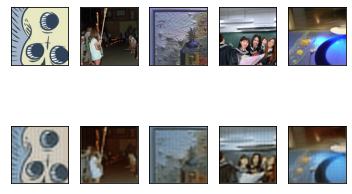

Epoch : [2/50] 

Train Loss: 0.02282	 val Loss: 0.01797	 lr : 0.001
EarlyStopping counter: 1 out of 10
PNSR :14.89 	 SSIM : 0.57
PNSR :17.74 	 SSIM : 0.58
PNSR :18.09 	 SSIM : 0.42
PNSR :17.09 	 SSIM : 0.56
PNSR :16.07 	 SSIM : 0.73
average_PNSR :16.77 	 average_SSIM : 0.57


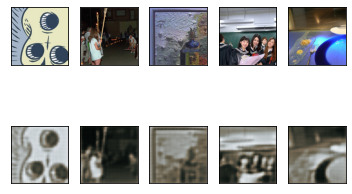

Epoch : [3/50] 

Train Loss: 0.01338	 val Loss: 0.01193	 lr : 0.001
Validation loss decreased (0.014577 --> 0.011933).  Saving model ...
PNSR :16.10 	 SSIM : 0.63
PNSR :18.74 	 SSIM : 0.62
PNSR :19.39 	 SSIM : 0.45
PNSR :18.28 	 SSIM : 0.62
PNSR :21.34 	 SSIM : 0.79
average_PNSR :18.77 	 average_SSIM : 0.62


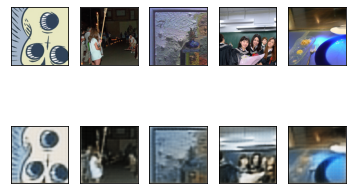

Epoch : [4/50] 

Train Loss: 0.01130	 val Loss: 0.01066	 lr : 0.001
Validation loss decreased (0.011933 --> 0.010661).  Saving model ...
PNSR :16.69 	 SSIM : 0.66
PNSR :19.33 	 SSIM : 0.64
PNSR :19.80 	 SSIM : 0.48
PNSR :19.27 	 SSIM : 0.67
PNSR :22.22 	 SSIM : 0.80
average_PNSR :19.46 	 average_SSIM : 0.65


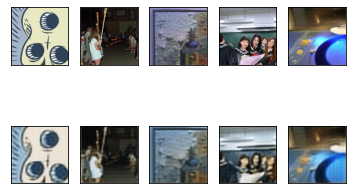

Epoch : [5/50] 

Train Loss: 0.01023	 val Loss: 0.01021	 lr : 0.001
Validation loss decreased (0.010661 --> 0.010207).  Saving model ...
PNSR :17.10 	 SSIM : 0.68
PNSR :19.90 	 SSIM : 0.67
PNSR :19.88 	 SSIM : 0.49
PNSR :19.52 	 SSIM : 0.69
PNSR :22.16 	 SSIM : 0.81
average_PNSR :19.71 	 average_SSIM : 0.67


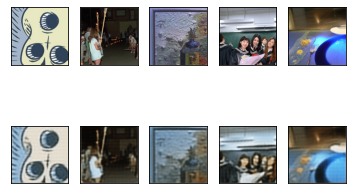

Epoch : [6/50] 

Train Loss: 0.00956	 val Loss: 0.01011	 lr : 0.001
EarlyStopping counter: 1 out of 10
PNSR :17.35 	 SSIM : 0.70
PNSR :20.15 	 SSIM : 0.68
PNSR :19.75 	 SSIM : 0.50
PNSR :19.66 	 SSIM : 0.71
PNSR :22.33 	 SSIM : 0.83
average_PNSR :19.85 	 average_SSIM : 0.68


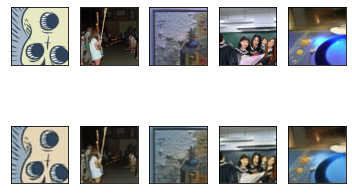

Epoch : [7/50] 

Train Loss: 0.00939	 val Loss: 0.00924	 lr : 0.001
Validation loss decreased (0.010207 --> 0.009244).  Saving model ...
PNSR :18.13 	 SSIM : 0.72
PNSR :20.27 	 SSIM : 0.68
PNSR :20.20 	 SSIM : 0.52
PNSR :20.11 	 SSIM : 0.72
PNSR :22.72 	 SSIM : 0.82
average_PNSR :20.29 	 average_SSIM : 0.69


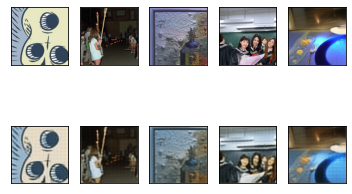

Epoch : [8/50] 

Train Loss: 0.00916	 val Loss: 0.00900	 lr : 0.001
Validation loss decreased (0.009244 --> 0.008997).  Saving model ...
PNSR :18.28 	 SSIM : 0.74
PNSR :20.41 	 SSIM : 0.70
PNSR :20.28 	 SSIM : 0.53
PNSR :20.24 	 SSIM : 0.73
PNSR :22.65 	 SSIM : 0.83
average_PNSR :20.37 	 average_SSIM : 0.71


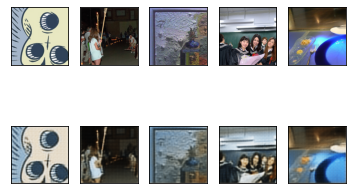

Epoch : [9/50] 

Train Loss: 0.00876	 val Loss: 0.00904	 lr : 0.001
EarlyStopping counter: 1 out of 10
PNSR :18.44 	 SSIM : 0.74
PNSR :20.26 	 SSIM : 0.69
PNSR :20.32 	 SSIM : 0.53
PNSR :20.25 	 SSIM : 0.73
PNSR :22.75 	 SSIM : 0.83
average_PNSR :20.40 	 average_SSIM : 0.71


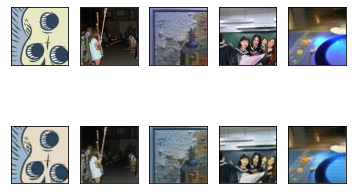

Epoch : [10/50] 

Train Loss: 0.00868	 val Loss: 0.00876	 lr : 0.001
Validation loss decreased (0.008997 --> 0.008761).  Saving model ...
PNSR :18.63 	 SSIM : 0.75
PNSR :20.48 	 SSIM : 0.70
PNSR :20.35 	 SSIM : 0.54
PNSR :20.40 	 SSIM : 0.74
PNSR :22.85 	 SSIM : 0.83
average_PNSR :20.54 	 average_SSIM : 0.71


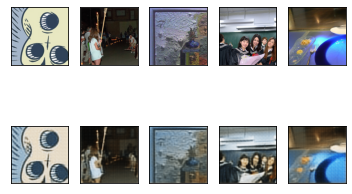

Epoch : [11/50] 

Train Loss: 0.00861	 val Loss: 0.00858	 lr : 0.001
Validation loss decreased (0.008761 --> 0.008575).  Saving model ...
PNSR :18.90 	 SSIM : 0.77
PNSR :20.58 	 SSIM : 0.71
PNSR :20.40 	 SSIM : 0.55
PNSR :20.51 	 SSIM : 0.74
PNSR :22.79 	 SSIM : 0.84
average_PNSR :20.63 	 average_SSIM : 0.72


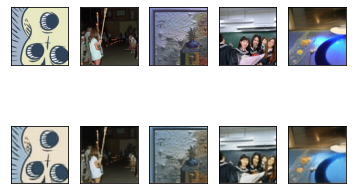

Epoch : [12/50] 

Train Loss: 0.00840	 val Loss: 0.00847	 lr : 0.001
Validation loss decreased (0.008575 --> 0.008466).  Saving model ...
PNSR :19.03 	 SSIM : 0.77
PNSR :20.63 	 SSIM : 0.71
PNSR :20.45 	 SSIM : 0.55
PNSR :20.59 	 SSIM : 0.75
PNSR :22.98 	 SSIM : 0.84
average_PNSR :20.74 	 average_SSIM : 0.72


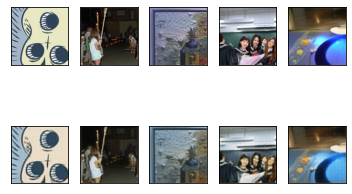

Epoch : [13/50] 

Train Loss: 0.00829	 val Loss: 0.00837	 lr : 0.001
EarlyStopping counter: 1 out of 10
PNSR :19.11 	 SSIM : 0.78
PNSR :20.63 	 SSIM : 0.71
PNSR :20.50 	 SSIM : 0.55
PNSR :20.64 	 SSIM : 0.75
PNSR :23.06 	 SSIM : 0.84
average_PNSR :20.79 	 average_SSIM : 0.73


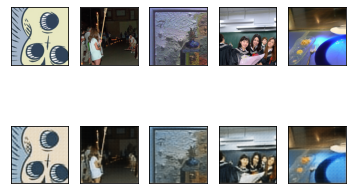

Epoch : [14/50] 

Train Loss: 0.00826	 val Loss: 0.00829	 lr : 0.001
Validation loss decreased (0.008466 --> 0.008286).  Saving model ...
PNSR :19.17 	 SSIM : 0.78
PNSR :20.65 	 SSIM : 0.71
PNSR :20.52 	 SSIM : 0.55
PNSR :20.69 	 SSIM : 0.75
PNSR :23.11 	 SSIM : 0.84
average_PNSR :20.83 	 average_SSIM : 0.73


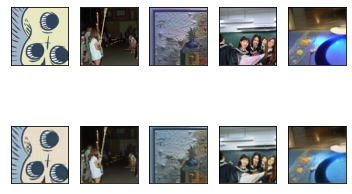

Epoch : [15/50] 

Train Loss: 0.02511	 val Loss: 0.02099	 lr : 0.001
EarlyStopping counter: 1 out of 10
PNSR :14.11 	 SSIM : 0.56
PNSR :16.97 	 SSIM : 0.55
PNSR :17.44 	 SSIM : 0.40
PNSR :15.84 	 SSIM : 0.52
PNSR :15.67 	 SSIM : 0.72
average_PNSR :16.01 	 average_SSIM : 0.55


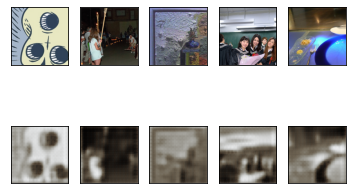

Epoch : [16/50] 

Train Loss: 0.01872	 val Loss: 0.01739	 lr : 0.001
EarlyStopping counter: 2 out of 10
PNSR :15.21 	 SSIM : 0.61
PNSR :18.52 	 SSIM : 0.60
PNSR :17.99 	 SSIM : 0.44
PNSR :17.52 	 SSIM : 0.60
PNSR :15.87 	 SSIM : 0.75
average_PNSR :17.02 	 average_SSIM : 0.60


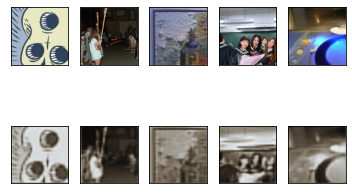

Epoch : [17/50] 

Train Loss: 0.01685	 val Loss: 0.01664	 lr : 0.001
EarlyStopping counter: 3 out of 10
PNSR :15.49 	 SSIM : 0.63
PNSR :18.82 	 SSIM : 0.62
PNSR :18.08 	 SSIM : 0.45
PNSR :17.87 	 SSIM : 0.62
PNSR :15.93 	 SSIM : 0.76
average_PNSR :17.24 	 average_SSIM : 0.62


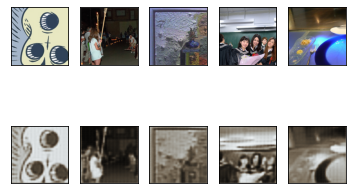

Epoch : [18/50] 

Train Loss: 0.01629	 val Loss: 0.01607	 lr : 0.001
EarlyStopping counter: 4 out of 10
PNSR :15.84 	 SSIM : 0.66
PNSR :19.04 	 SSIM : 0.64
PNSR :18.12 	 SSIM : 0.47
PNSR :18.27 	 SSIM : 0.65
PNSR :15.93 	 SSIM : 0.77
average_PNSR :17.44 	 average_SSIM : 0.64


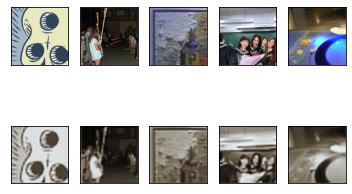

Epoch : [19/50] 

Train Loss: 0.01580	 val Loss: 0.01552	 lr : 0.001
EarlyStopping counter: 5 out of 10
PNSR :16.22 	 SSIM : 0.68
PNSR :19.33 	 SSIM : 0.65
PNSR :18.17 	 SSIM : 0.48
PNSR :18.63 	 SSIM : 0.67
PNSR :15.93 	 SSIM : 0.77
average_PNSR :17.65 	 average_SSIM : 0.65


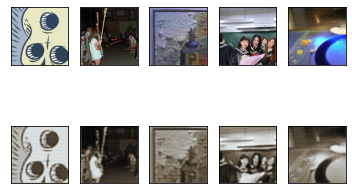

Epoch : [20/50] 

Train Loss: 0.01507	 val Loss: 0.01486	 lr : 0.001
EarlyStopping counter: 6 out of 10
PNSR :16.81 	 SSIM : 0.70
PNSR :19.80 	 SSIM : 0.66
PNSR :18.36 	 SSIM : 0.51
PNSR :19.03 	 SSIM : 0.69
PNSR :16.00 	 SSIM : 0.78
average_PNSR :18.00 	 average_SSIM : 0.67


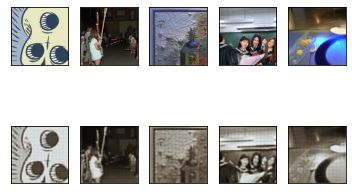

Epoch : [21/50] 

Train Loss: 0.01292	 val Loss: 0.00994	 lr : 0.001
EarlyStopping counter: 7 out of 10
PNSR :17.89 	 SSIM : 0.72
PNSR :19.99 	 SSIM : 0.67
PNSR :20.01 	 SSIM : 0.52
PNSR :19.96 	 SSIM : 0.71
PNSR :21.60 	 SSIM : 0.80
average_PNSR :19.89 	 average_SSIM : 0.68


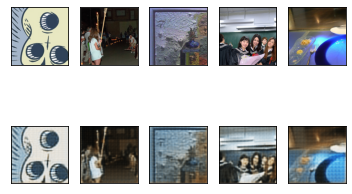

Epoch : [22/50] 

Train Loss: 0.00912	 val Loss: 0.00965	 lr : 0.001
EarlyStopping counter: 8 out of 10
PNSR :18.21 	 SSIM : 0.75
PNSR :20.24 	 SSIM : 0.69
PNSR :19.84 	 SSIM : 0.53
PNSR :19.97 	 SSIM : 0.73
PNSR :21.73 	 SSIM : 0.82
average_PNSR :20.00 	 average_SSIM : 0.70


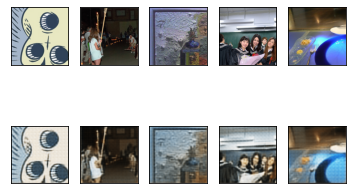

Epoch : [23/50] 

Train Loss: 0.00882	 val Loss: 0.00914	 lr : 0.001
EarlyStopping counter: 9 out of 10
PNSR :18.57 	 SSIM : 0.76
PNSR :20.46 	 SSIM : 0.71
PNSR :20.09 	 SSIM : 0.54
PNSR :20.22 	 SSIM : 0.74
PNSR :22.15 	 SSIM : 0.83
average_PNSR :20.30 	 average_SSIM : 0.71


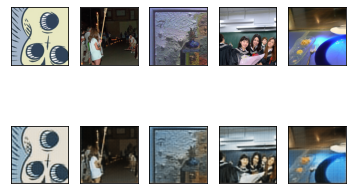

Epoch : [24/50] 

Train Loss: 0.00855	 val Loss: 0.00861	 lr : 0.001
EarlyStopping counter: 10 out of 10
Early stopping
execution time : 10.2min


In [12]:
n_epochs = 50

device = get_device()
print(device)

# MSE
mse_loss_fn = nn.MSELoss().to(device)

# # SSIM
# ms_ssim_loss_fn = MS_SSIM_Loss(data_range = 1.0, size_average = True, channel = 3).to(device)


model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-04)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=5, mode='min')    
early_stopping = EarlyStopping(patience = 10, delta = 1e-4, verbose = True)


start = time.time()


for epoch in range(1, n_epochs+1):
    torch.cuda.max_memory_allocated(device=device)
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []

    for i,tr_img in enumerate(tr_dataloader):

        tr_img = tr_img.to(device)
        tr_outputs = model(tr_img)
        optimizer.zero_grad()

        # MSE
        loss = mse_loss_fn(tr_outputs, tr_img)
        loss.backward()

        # # SSIM
        # loss = ms_ssim_loss_fn(tr_outputs, tr_img)
        # loss.backward()

        optimizer.step()

        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        for i, val_img in enumerate(val_dataloader):
                val_img = val_img.to(device)
                val_outputs = model(val_img)

                # MSE
                val_loss = mse_loss_fn(val_outputs, val_img)

                # # SSIM
                # val_loss = ms_ssim_loss_fn(val_outputs, val_img)

                valid_losses.append(val_loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))
        print('Train Loss: {:.5f}\t val Loss: {:.5f}\t lr : {}'.format(train_loss, valid_loss,
                                                                           scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

        train_losses = []
        valid_losses = []
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        if (epoch)%1 == 0:
            total_psnr = 0
            total_ssim = 0
            for j in range(5):
                val_ssim = skimage_ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True)
                val_psnr = peak_signal_noise_ratio(val_img[j].cpu().numpy().transpose(1,2,0), val_outputs[j].cpu().numpy().transpose(1,2,0))
                total_psnr += val_psnr
                total_ssim += val_ssim
                print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
                ax = plt.subplot(2,5,j+1)
                plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax = plt.subplot(2,5,j+5+1)
                plt.imshow(val_outputs[j].cpu().numpy().transpose(1, 2, 0))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            print('average_PNSR :{:.2f} \t average_SSIM : {:.2f}'.format(total_psnr/5,total_ssim/5))
            plt.show()
    
end = time.time()

total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

# TEST

In [16]:
from torchvision.datasets.folder import IMG_EXTENSIONS
import os
from typing import List

def collect_img(rootpath: str) -> List[str]:
  return [
          os.path.join(rootpath, f)
          for f in os.listdir(rootpath)
          if os.path.splitext(f)[-1].lower() in IMG_EXTENSIONS
  ]

def read_img(filepath: str) -> torch.Tensor:
  img = Image.open(filepath).convert('RGB')
  return transforms.ToTensor()(img)

In [17]:
device = get_device()

root_path = '/content/drive/MyDrive/KODAK_5'
file_path = collect_img(root_path)

model = Autoencoder().to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/ckpt/checkpoint.pt'))
compression_rate = '560_MSE_'


model.eval()

total_psnr = 0
total_ssim = 0

for f in file_path:
  data = read_img(f).to(device)
  name = os.path.basename(os.path.normpath(f))

  test_img = data.unsqueeze(0)
  recon = model(test_img)

  save_image(recon, '/content/drive/MyDrive/recon/recon_' + compression_rate + name)
  val_ssim = skimage_ssim(test_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0), recon.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0), multichannel=True)
  val_psnr = peak_signal_noise_ratio(test_img.detach().cpu().numpy().squeeze(0).transpose(1,2,0), recon.detach().cpu().numpy().squeeze(0).transpose(1,2,0))
  total_psnr+=val_psnr
  total_ssim+=val_ssim
  print('PNSR :{:.3f} \t SSIM : {:.3f}'.format(val_psnr,val_ssim))

print('avg_Psnr :{:.3f} \t avg_Ssim : {:.3f}'.format(total_psnr/5, total_ssim/5))

PNSR :23.134 	 SSIM : 0.812
PNSR :25.816 	 SSIM : 0.859
PNSR :26.613 	 SSIM : 0.855
PNSR :22.954 	 SSIM : 0.724
PNSR :23.361 	 SSIM : 0.774
avg_Psnr :24.376 	 avg_Ssim : 0.805
